In [184]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import numpy as np

import torchvision
import tqdm
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [185]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=torchvision.transforms.ToTensor(), download=True)


In [186]:
# Create the dataloader
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

tensor(1.)
torch.Size([32, 1, 28, 28])


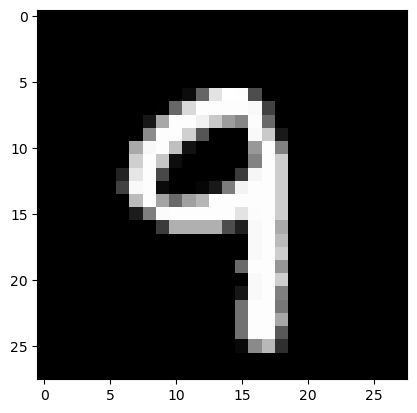

In [191]:
# Take a look at the data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
# Print the maximum value of the data
print(example_data.max())
print(example_data.shape)
plt.imshow(example_data[0][0], cmap='gray')

In [199]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # We will store the encoder as a sequential object and the decoder as a ModuleDict.
        # Note a few key differences between these storage methods:
        # 1. Sequential takes in a sequence of arguments, with each argument being a layer, while ModuleDict takes in a dictionary.
        # 2. Sequential stores the layers in order, while ModuleDict stores the layers in an unordered dictionary.
        # 3. A Sequential object can be called like a function (i.e., self.encoder(x)), while a ModuleDict cannot.
        # 4. A Sequential object contains layers with no learnable parameters, which the ModuleDict does not.
        # 5. Layers are accessed by their name in a ModuleDict, while they are accessed by their index in a Sequential object.


        # Keep track of the size of the data as it is passed through. We ignore the batch size.
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),  # output shape is (16, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # output shape is (16, 13, 13)
            nn.Conv2d(16, 32, kernel_size=4),  # output shape is (32, 10, 10)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # output shape is (32, 5, 5)
            nn.Conv2d(32, 8, kernel_size=2),  # output shape is (8, 4, 4)
            nn.ReLU(),
            nn.Flatten(), # output shape is (8 * 4 * 4)
            nn.Linear(8 * 4 * 4, 16), # output shape is (16)
        )

        # Note - the nn.ConvTranspose2d layers are the opposite of nn.Conv2d layers.
        self.decoder = nn.ModuleDict({
            'fc': nn.Linear(16, 8 * 6 * 6), # output shape is (8 * 6 * 6)
            'Deconv1': nn.ConvTranspose2d(8, 32, kernel_size=3), # output shape is (32, 8, 8)
            'Deconv2': nn.ConvTranspose2d(32, 16, kernel_size=4), # output shape is (16, 11, 11)
            'Deconv3': nn.ConvTranspose2d(16, 8, kernel_size=4), # output shape is (18, 25, 25)
            'Deconv4': nn.ConvTranspose2d(8, 1, kernel_size=4) # output shape is (1, 28, 28)
        })

    def forward(self, x):
        # Call the encoder on the input to get the latent representation z
        z = self.encoder(x)

        # Pass the latent representation z through the decoder. Note that we must call each layer in order from the ModuleDict.
        z = self.decoder['fc'](z)
        z = F.relu(z) # z has shape (8 * 6 * 6)
        z = z.view(-1, 8, 6, 6) # reshape z to (8, 6, 6)
        z = self.decoder['Deconv1'](z) # output shape is (32, 8, 8)
        z = F.relu(z)
        z = self.decoder['Deconv2'](z) # output shape is (16, 11, 11)
        z = F.relu(z)
        z = F.interpolate(z, scale_factor=2) # output shape is (16, 22, 22)
        z = self.decoder['Deconv3'](z) # output shape is (16, 25, 25)
        z = F.relu(z)
        z = self.decoder['Deconv4'](z) # output shape is (1, 28, 28)
        z = F.relu(z) 
        return z

    # This function is used to encode the input x to the latent representation z.
    def encode(self, x):
        z = self.encoder(x)
        return z


In [200]:
my_network = AutoEncoder()
optimiser = optim.Adam(my_network.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [201]:
# Check that the input and output shapes match
data, target = next(iter(train_loader))
print(data.shape)
my_network(data).shape

torch.Size([32, 1, 28, 28])


torch.Size([32, 1, 28, 28])

In [202]:
losses = []
for i in range(6):
    for data, target in tqdm.tqdm(train_loader):
        optimiser.zero_grad() # Reset the gradients
        output = my_network(data) # Pass the data through the network
        loss = loss_function(output, data) # Calculate the reconstruction loss - i.e. the MSE between the input and output
        loss.backward() # Backpropagate the loss
        optimiser.step() # Update the weights
        losses.append(loss.detach().numpy()) # Save the loss for plotting later
    print('Epoch {} finished'.format(i+1)) 

100%|██████████| 1875/1875 [01:00<00:00, 30.90it/s]


Epoch 1 finished


100%|██████████| 1875/1875 [01:03<00:00, 29.60it/s]


Epoch 2 finished


100%|██████████| 1875/1875 [01:13<00:00, 25.50it/s]


Epoch 3 finished


100%|██████████| 1875/1875 [01:00<00:00, 30.81it/s]


Epoch 4 finished


100%|██████████| 1875/1875 [00:59<00:00, 31.52it/s]


Epoch 5 finished


100%|██████████| 1875/1875 [00:56<00:00, 33.29it/s]

Epoch 6 finished


(0.0, 11150.0)

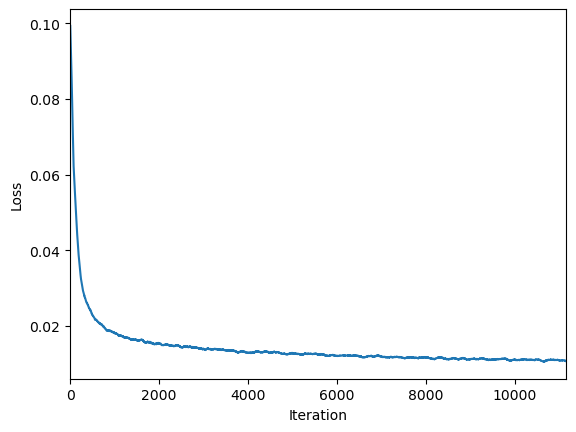

In [203]:
# Plot a smoothed version of the losses
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.ylim([0, 0.1])
plt.xlim([0, len(losses)-100])


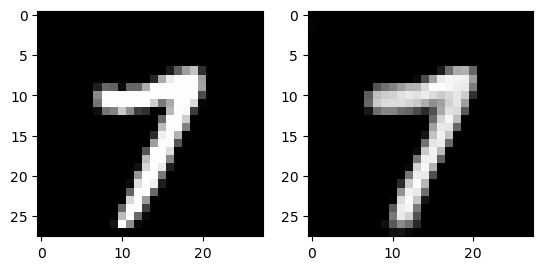

In [210]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = my_network(example_data)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(example_data[0][0], cmap='gray')
    ax[1].imshow(output[0][0], cmap='gray')

In [211]:
# Pass the test data into the encoder to get the latent representations
Z = torch.zeros((len(test_dataset), 16))
with torch.no_grad():
    k = 0
    for data, target in tqdm.tqdm(test_loader):
        z = my_network.encode(data)
        Z[(k * batch_size):(k*batch_size)+len(data)] = z

  3%|▎         | 10/313 [00:00<00:03, 94.76it/s]

100%|██████████| 313/313 [00:02<00:00, 104.92it/s]


(0.0, 16.0)

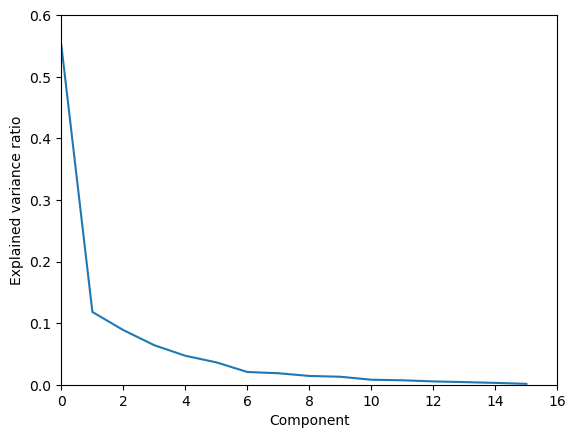

In [214]:
# Perform PCA on the encoded data
pca = PCA(n_components=16)
pca.fit(Z)
Z_pca = pca.transform(Z)

# Plot a scree plot of the PCA
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.ylim([0, 0.6])
plt.xlim([0, 16])

Text(0.5, 1.0, 'PCA of encoded MNIST data')

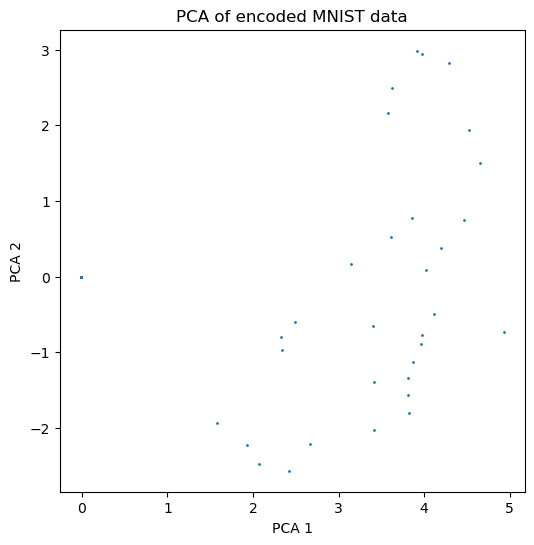

In [215]:
# Plot the encoded data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(Z_pca[:, 0], Z_pca[:, 1], s = 1)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('PCA of encoded MNIST data')

In [216]:
# Perform K-means clustering on the encoded data
# Iterate through cluster numbers to find the cluster with the highest silhouette score
scores = []
for k in tqdm.tqdm(range(2, 14)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Z_pca)
    scores.append(silhouette_score(Z_pca, kmeans.labels_))

  0%|          | 0/12 [00:00<?, ?it/s]

c:\Users\edwar\miniconda3\envs\comp_neuro\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  8%|▊         | 1/12 [00:04<00:48,  4.44s/it]c:\Users\edwar\miniconda3\envs\comp_neuro\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 17%|█▋        | 2/12 [00:06<00:31,  3.16s/it]c:\Users\edwar\miniconda3\envs\comp_neuro\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 25%|██▌       | 3/12 [00:08<00:

(2.0, 14.0)

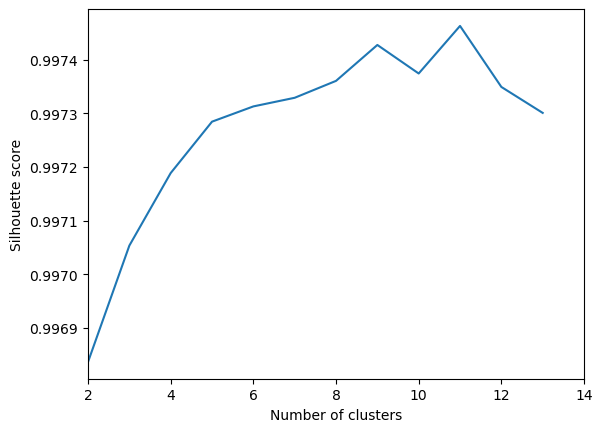

In [217]:
# Plot the silhouette scores
plt.plot(range(2, 14), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xlim([2, 14])
